#### 包导入、系统配置

In [1]:
import os
import re

import pandas as  pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm

import statsmodels.api as sm
import statsmodels.formula.api as smf
from scipy.stats import chi2_contingency

from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier,AdaBoostClassifier,GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier

from sklearn.model_selection import ShuffleSplit,cross_val_score,train_test_split
from sklearn import metrics


import seaborn as sns

import warnings

In [2]:
warnings.filterwarnings("ignore")

inputpath = "../data/"
outputpath = "../output/"


figsize = (20,15)
plt.rcParams['font.sans-serif'] = ['SimHei']  # 用来正常显示中文标签
plt.rcParams['axes.unicode_minus'] = False  # 用来正常显示负号
plt.rcParams["savefig.dpi"] = 500
plt.rcParams["figure.figsize"] = (20,15)
plt.rcParams["figure.subplot.hspace"] = 0.2
plt.rcParams["figure.subplot.wspace"] = 0.05
plt.rcParams["lines.linewidth"] = 3
plt.rcParams["xtick.labelsize"] = 14
plt.rcParams["ytick.labelsize"] = 10
plt.rcParams["legend.loc"] = "upper left"
# plt.style.use("seaborn-poster")

def num2color(values, cmap="RdBu"):
    """将数值映射为颜色"""
    norm = mpl.colors.Normalize(vmin=np.min(values), vmax=np.max(values))
    cmap = mpl.cm.get_cmap(cmap)
    return [cmap(norm(val)) for val in values]


colormap1 = ["saddlebrown","dodgerblue"]
colormap2 = "Blues"
# plt.rcdefaults()   # 恢复默认配置

In [3]:
inputdata = pd.read_csv(os.path.join(inputpath,"真假招聘信息.csv"))

In [4]:

temp = pd.DataFrame(index=[list(inputdata.columns) * 14])
val = np.random.randint(0,10,14)
temp.loc[inputdata.columns[0],"x"] = val
temp.loc[inputdata.columns[0],:]

,x
department,4.0
department,7.0
department,5.0
department,9.0
department,4.0
department,9.0
department,0.0
department,0.0
department,5.0
department,3.0


In [5]:
# 1.数据格式预处理：字符修正、设置id变量
inputdata1 = inputdata.copy()

codingmap = {"unknown":"未知","other":"其他",
             0:"否",1:"是",
             "positive":"积极","negative":"消极", "neutral":"中立",
             "less-5000":"低于5000", "5000-50000":"5000-50000", "more-50000":"高于50000",
             "clerical":"文员", "engineering":"工程","marketing":"市场", "sales":"销售","service":"服务",
             "contract":"合同制", "full-time":"全职", "part-time":"兼职","temporary":"临时",
             "associate":"助理", "director":"主管", "entry level":"入门级","executive":"执行级","internship":"实习","mid-senior level":"中高级", "not applicable":"不适用",
             "bachelor's degree":"学士","high school or equivalent":"高中或同等学历","master's degree":"硕士", "some high school coursework":"一些高中课程", "unspecified":"不确定",
             "accounting":"会计","computer":"计算机",  "health":"健康", "internet":"互联网", "leisure":"休闲", "marketing":"营销", "media":"媒体", "oil":"石油","real":"房地产",  "services":"服务",  "telecommunications":"电信",
             "au":"非洲联盟", "de":"德国", "gb":"英国", "gr":"希腊", "nz":"新西兰", "us":"美国",
             }
columnmap = {"fraudulent":"是否为虚假招聘信息",
             "description":"公司基本信息",
             "requirements":"岗位要求",
             "benefits":"工作福利",
             "department":"工作部门",
             "salary":"薪资范围",
             "telecommuting":"是否接受远程办公",
             "logo":"公司是否有标志",
             "type":"工作类型",
             "experience":"经验要求",
             "education":"学历要求",
             "industry":"公司行业类别",
             "country":"公司地点",
             "index":"id"
            }

for x in inputdata.columns:
    if x not in ["telecommuting", "logo", "fraudulent"]:
        inputdata1[x] = inputdata1.loc[:,x].str.lower()
        inputdata1[x] = inputdata1[x].map(lambda  x : x.replace("0other","other"))
        inputdata1[x] = inputdata1[x].map(codingmap)
    if x in ["telecommuting", "logo","fraudulent"]:
        inputdata1[x] = inputdata1[x].map(codingmap)
inputdata2 = inputdata1.reset_index().rename(columns=columnmap)

Adata = inputdata2.copy()

In [6]:
def descri(data,index,columns="是否为虚假招聘信息"):
    """
    描述性统计结果
    单变量卡方检验
    """
    tempdata1 = pd.crosstab(index=data[index],columns=data[columns])
    tempdata1.loc[:,"Variable"]  = index
    # 计算频数、频率
    tempdata1["prob_True"] = np.round(tempdata1["否"] / data.shape[0] * 100,2).astype(str) + "%"
    tempdata1["prob_False"] = round(tempdata1["是"] / data.shape[0] * 100,2).astype(str) + "%"
    tempdata1["False：Overall Sample N(%)"] = tempdata1["否"].astype(str) +"(" + tempdata1["prob_True"] + ")"
    tempdata1["True：Overall Sample N(%)"] = tempdata1["是"].astype(str) +"(" + tempdata1["prob_False"] + ")"
    # 卡方检验
    chiq_test = chi2_contingency(tempdata1.loc[:,["否","是"]])
    tempdata1["Chiq"] = "{:.3f}".format(chiq_test[0])
    # 显著性检验
    if chiq_test[1] < 0.001:
        tempdata1["P Value"] = "<0.001(***)"
    elif chiq_test[1] <0.01:
        tempdata1["P Value"] = "{:.3f}(**)".format(chiq_test[1])
    elif chiq_test[1] <0.05:
        tempdata1["P Value"] = "{:.3f}(*)".format(chiq_test[1])
    
    tempdata2 = tempdata1.reset_index().rename(columns={index:"Level"})
    
    return tempdata2

# 对所有变量进行计算（描述性统计）
flag = 0
for col in Adata.columns:
    
    if col not in ["是否为虚假招聘信息","id"]:
        
        tempdata3 = descri(data=Adata, index=col)
        
        if flag==0:
            tempdata4 = tempdata3
        else:
            tempdata4 = pd.concat([tempdata4,tempdata3]) 
            
        flag += 1

outputdata1 = tempdata4[["Variable", "Level", "False：Overall Sample N(%)", "True：Overall Sample N(%)", "Chiq", "P Value"]].copy()
outputdata1.to_csv(os.path.join(outputpath,"outputdata1_描述性统计结果.csv"), encoding="utf_8_sig")

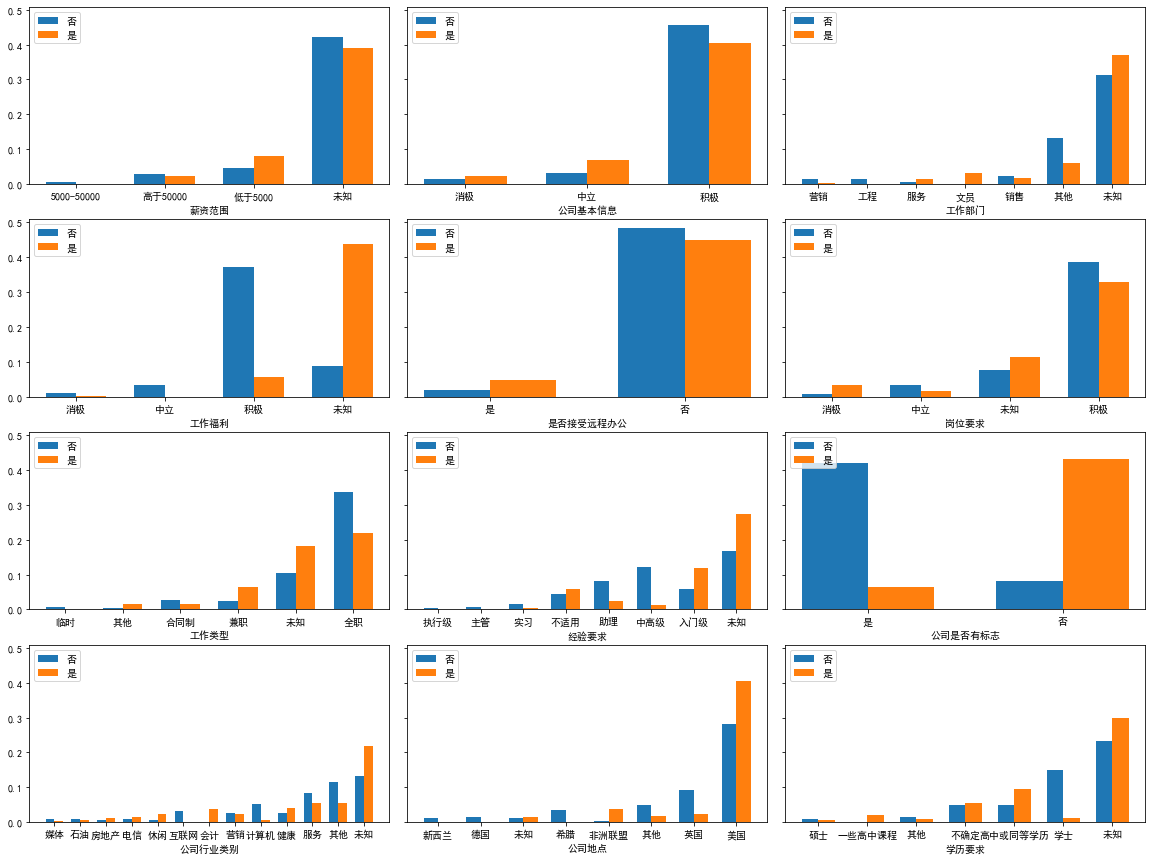

In [7]:
# 可视化描述
fig, ax = plt.subplots(4,3,sharey=True)

for i in range(len(tempdata4["Variable"].unique())):
    # 绘图数据整理
    tempdata5 = tempdata4.loc[tempdata4["Variable"]==tempdata4["Variable"].unique()[i],
                              ["Level","否","是"]].set_index("Level") / Adata.shape[0]
    tempdata5["marge_sum"] = tempdata5.sum(axis=1)
    tempdata5.sort_values("marge_sum", inplace =True)
    width=0.34
    x = np.arange(len(tempdata5.index))
    
    # 子图绘制
    rects1 = ax[i//3,i%3-1].bar(x-width/2, tempdata5["否"], width, label='否')
    rects2 = ax[i//3,i%3-1].bar(x+width/2, tempdata5["是"], width, label='是')
    
    ax[i//3,i%3-1].set_xlabel(tempdata4["Variable"].unique()[i])
    ax[i//3,i%3-1].set_xticks(x)
    ax[i//3,i%3-1].set_xticklabels(tempdata5.index,rotation=0,fontsize=10)
    ax[i//3,i%3-1].legend(loc="upper left")
# plt.subplots_adjust(wspace=0.05)
plt.savefig(os.path.join(outputpath,"outputplot1_频率直方图.png"),bbox_inches = "tight")


#### 数据集划分

In [8]:
# 逻辑回归：数据集整理
AdataTemp = Adata.copy()
AdataTemp["是否为虚假招聘信息"] = AdataTemp["是否为虚假招聘信息"].map({"是":1,"否":0})
AdataTemp.to_csv(os.path.join(outputpath,"outputdata_逻辑回归分析数据.csv"),encoding="utf_8_sig",index=False)

# 机器学习：哑变量编码
X_data = pd.get_dummies( Adata.drop(["id","是否为虚假招聘信息"],axis=1))
Y_data = Adata["是否为虚假招聘信息"].map({"是":1,"否":0})

# 逻辑回归参数检验：数据集划分
tdata = AdataTemp.iloc[AdataTemp.loc[AdataTemp["是否为虚假招聘信息"]==1,"id"].index,:]
fdata = AdataTemp.iloc[AdataTemp.loc[AdataTemp["是否为虚假招聘信息"]==0,"id"].index,:]

tdata2_train = tdata.sample(int(len(tdata) * 0.7),random_state=123)
tdata2_test = pd.concat([tdata,tdata2_train]).drop_duplicates(keep=False)

fdata2_train = fdata.sample(int(len(fdata) * 0.7),random_state=123)
fdata2_test = pd.concat([fdata,fdata2_train]).drop_duplicates(keep=False)

train_Adata = pd.concat([tdata2_train,fdata2_train])
test_Adata = pd.concat([tdata2_test,fdata2_test])

# 机器学习：数据集划分
X_train = X_data.iloc[train_Adata.index,:]
X_test = X_data.iloc[test_Adata.index,:]
Y_train = Y_data[train_Adata.index]
Y_test = Y_data[test_Adata.index]


Adata2 = train_Adata.copy()


In [9]:
# 模型字典
models = {
        "AdaBoost":AdaBoostClassifier(),
        "KNN":KNeighborsClassifier(),
        "Decision Tree":DecisionTreeClassifier(),
        "Logistic":LogisticRegression(),
        "GBDT":GradientBoostingClassifier(),
        "XGBoost":XGBClassifier(),
        "SVM":SVC(probability=True),
        "Random Forest":RandomForestClassifier(),
        "MLP":MLPClassifier() 
        }

#### 逻辑回归参数估计

In [11]:
# Logistic模型拟合
model = sm.GLM.from_formula("是否为虚假招聘信息 ~ {}".format("+".join(list(Adata2.columns[1:-1]))), 
                            family = sm.families.Binomial(), 
                            data=Adata2)
result = model.fit()

# 结果整理
res_logist = np.round(pd.concat([pd.DataFrame(result.params),
                                 result.bse,
                                 result.conf_int(), 
                                 result.tvalues,
                                 result.pvalues],axis=1),3).reset_index()

res_logist.columns = ["Var.Level","Estimate","Std.Err","95%Lower","95%Upper","Z-Value","p-Value"]
res_logist["Variables"] = res_logist["Var.Level"].str.replace("]","").str.replace("[","").str.split("T.").str[0]
res_logist["Level"] = res_logist["Var.Level"].str.replace("]","").str.replace("[","").str.split("T.").str[1]

# 对所有变量进行计算Odds/LogOdds
def deal_odds(data, index, column="是否为虚假招聘信息"):
    
    c = pd.crosstab(data[index], data[column])
    c = c.apply(lambda x: x/x.sum(), axis=1)
    c["Odds"] = c.loc[:, 1] / c.loc[:, 0]
    c["LogOdds"] = np.log(c["Odds"])
    c["Variables"] = index
    
    return c.reset_index().rename(columns={index:"Level"})

flag = 0
for col in Adata2.columns:
    
    if col not in ["是否为虚假招聘信息","id"]:
        
        tempodds1 = deal_odds(Adata2,col)
        
        if flag==0:
            tempodds2 = tempodds1
        else:
            tempodds2 = pd.concat([tempodds2,tempodds1]) 
            
        flag += 1
        
res_odds = np.round(tempodds2,3)

# 模型估计结果和Odds结果合并
res_logist_merge = res_logist.merge(res_odds.loc[:,["Variables","Level","Odds","LogOdds"]], how="outer",on=["Variables","Level"])

res_logist_merge["Odds"] = res_logist_merge["Odds"].replace({np.inf:">999.999", -np.inf:"<-999.999",0:"<0.001"})
res_logist_merge["LogOdds"] = res_logist_merge["LogOdds"].replace({np.inf:">999.999", -np.inf:"<-999.999",0:"<0.001"})

res_logist_merge.sort_values(["Variables","Level"],inplace=True)
res_logist_out = res_logist_merge[["Var.Level","Variables","Level","Estimate","Std.Err","95%Lower","95%Upper",
                                   "Z-Value","p-Value","Odds","LogOdds"]]
res_logist_out.rename(columns={
    "Var.Level":"变量-水平",
    "Variables":"变量名",
    "Level":"水平",
    "Estimate":"回归系数",
    "Std.Err":"标准误",
    "95%Lower":"0.95置信区间下限",
    "95%Upper":"0.95置信区间上限",
    "Z-Value":"Z-值",
    "p-Value":"P-值",
    "Odds":"几率",
    "LogOdds":"对数几率"
},inplace=True)
res_logist_out.to_csv(os.path.join(outputpath,"outputdata_逻辑回归参数估计结果.csv"),encoding="utf_8_sig",index=False)

#### 逻辑回归：结果评价

The accuracy of the Logistic Regression on train_predict is: 0.9072
The accuracy of the Logistic Regression on test_predict is: 0.8847583643122676


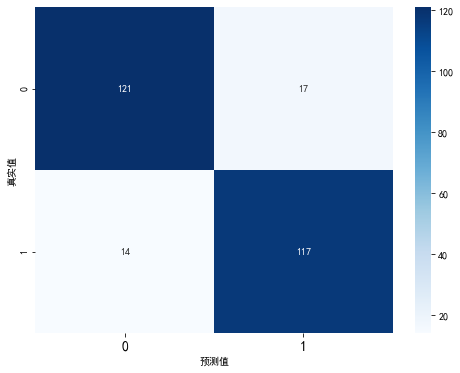

In [12]:
logit_clf = models["Logistic"].fit(X_train,Y_train)

## 在训练集和测试集上分布利用训练好的模型进行预测
train_predict = logit_clf.predict(X_train)
test_predict = logit_clf.predict(X_test)



## 利用accuracy（准确度）【预测正确的样本数目占总预测样本数目的比例】评估模型效果
print('The accuracy of the Logistic Regression on train_predict is:',metrics.accuracy_score(Y_train,train_predict))
print('The accuracy of the Logistic Regression on test_predict is:',metrics.accuracy_score(Y_test,test_predict))

# 利用热力图对于结果进行可视化
confusion_matrix_result = metrics.confusion_matrix(test_predict,Y_test)
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix_result, annot=True, cmap=colormap2,fmt='.50g')
plt.xlabel('预测值')
plt.ylabel('真实值')
plt.savefig(os.path.join(outputpath,"outputplot_逻辑回归混淆矩阵图.png"),dpi=500,bbox_inches = "tight")
plt.show()



<Figure size 1440x1080 with 0 Axes>

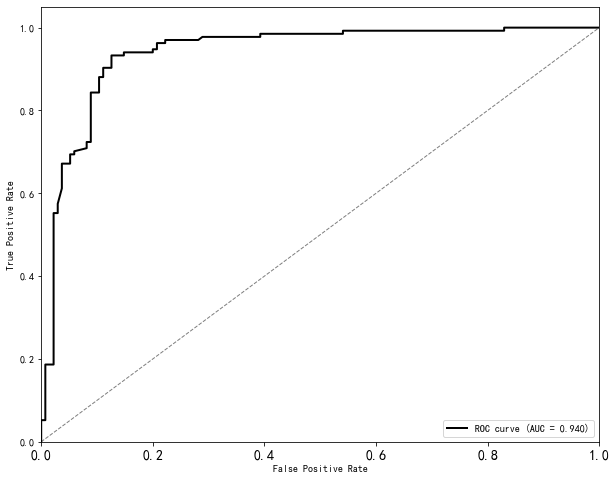

In [14]:
def acu_curve(y,prob):
    fpr,tpr,threshold = metrics.roc_curve(y,prob) ###计算真正率和假正率
    roc_auc = metrics.auc(fpr,tpr) ###计算auc的值
 
    plt.figure()
    lw = 2
    plt.figure(figsize=(10,8))
    plt.plot(fpr, tpr, color='black',
             lw=lw, label='ROC curve (AUC = %0.3f)' % roc_auc) ###假正率为横坐标，真正率为纵坐标做曲线
    plt.plot([0, 1], [0, 1], color='k', lw=1, linestyle='--',alpha=0.5)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc="lower right")

    
###通过decision_function()计算得到的y_score的值，用在roc_curve()函数中
y_score = logit_clf.fit(X_train, Y_train).decision_function(X_test)
acu_curve(Y_test,y_score)
plt.savefig(os.path.join(outputpath,"outputplot_逻辑回归ROC曲线图.png"),dpi=500,bbox_inches = "tight")
plt.show()

##### 变量重要性

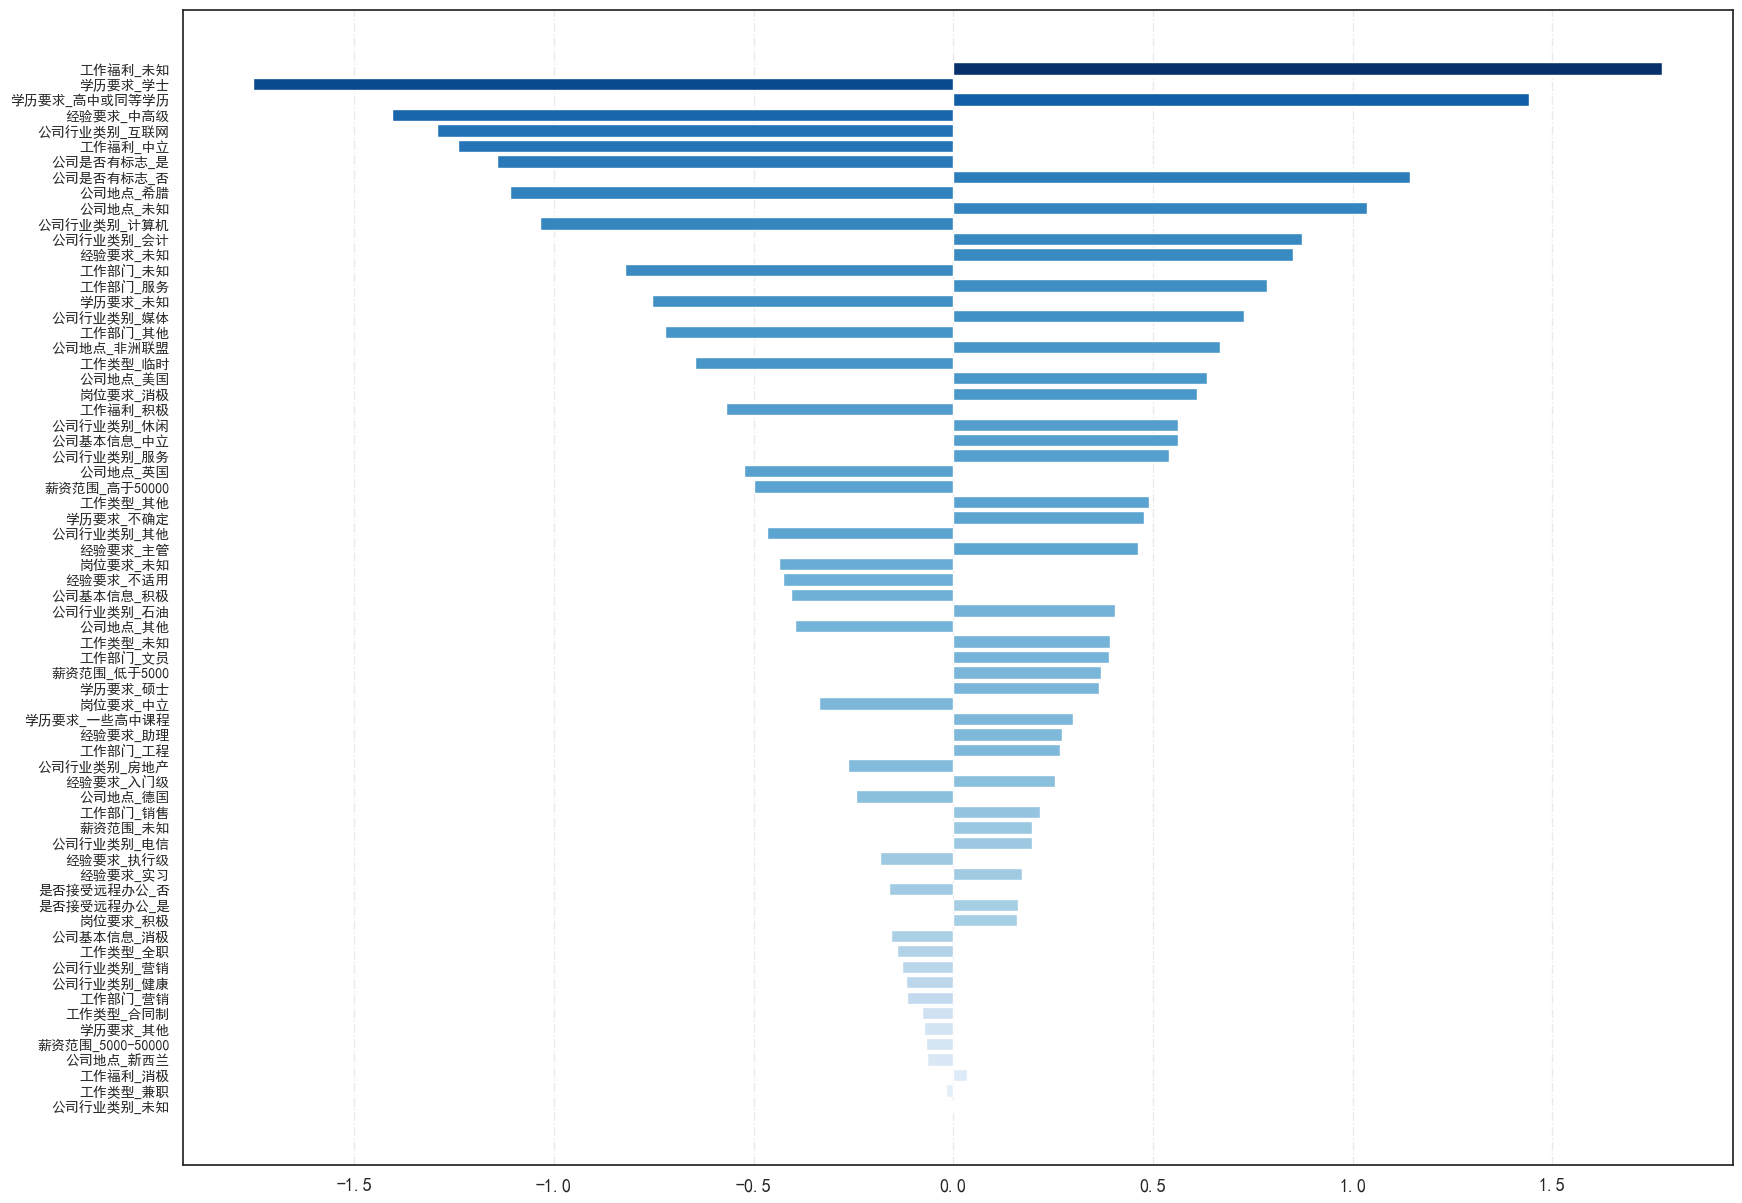

In [238]:
# 变量重要性排序
coef_lr = pd.DataFrame({'var' : X_test.columns,
                        'coef' : logit_clf.coef_.flatten()
                        })
coef_lr_sort0 = coef_lr.sort_values(["coef"],ascending=True)
index_sort =  np.abs(coef_lr['coef']).sort_values().index
coef_lr_sort = coef_lr.loc[index_sort,:]

# 水平柱形图绘图

fig,ax=plt.subplots(figsize=(20,15))
x, y = coef_lr_sort['var'], coef_lr_sort['coef']
map_vir = cm.get_cmap(name=colormap2)
norm_y = plt.Normalize(min(coef_lr_sort0["coef"]),max(coef_lr_sort0["coef"]))(coef_lr_sort0["coef"])
color = map_vir(norm_y)
rects = plt.barh(x, y, color=color)
plt.grid(linestyle="-.", axis='x', alpha=0.4)
plt.yticks(fontsize=10)
plt.xticks(fontsize=13)
plt.savefig(os.path.join(outputpath,"outputplot_逻辑回归变量重要性柱状图2.png"),dpi=500,bbox_inches = "tight")
plt.show()


#### 机器学习：模型交叉验证对比

##### 混淆矩阵可视化

[20:04:25] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


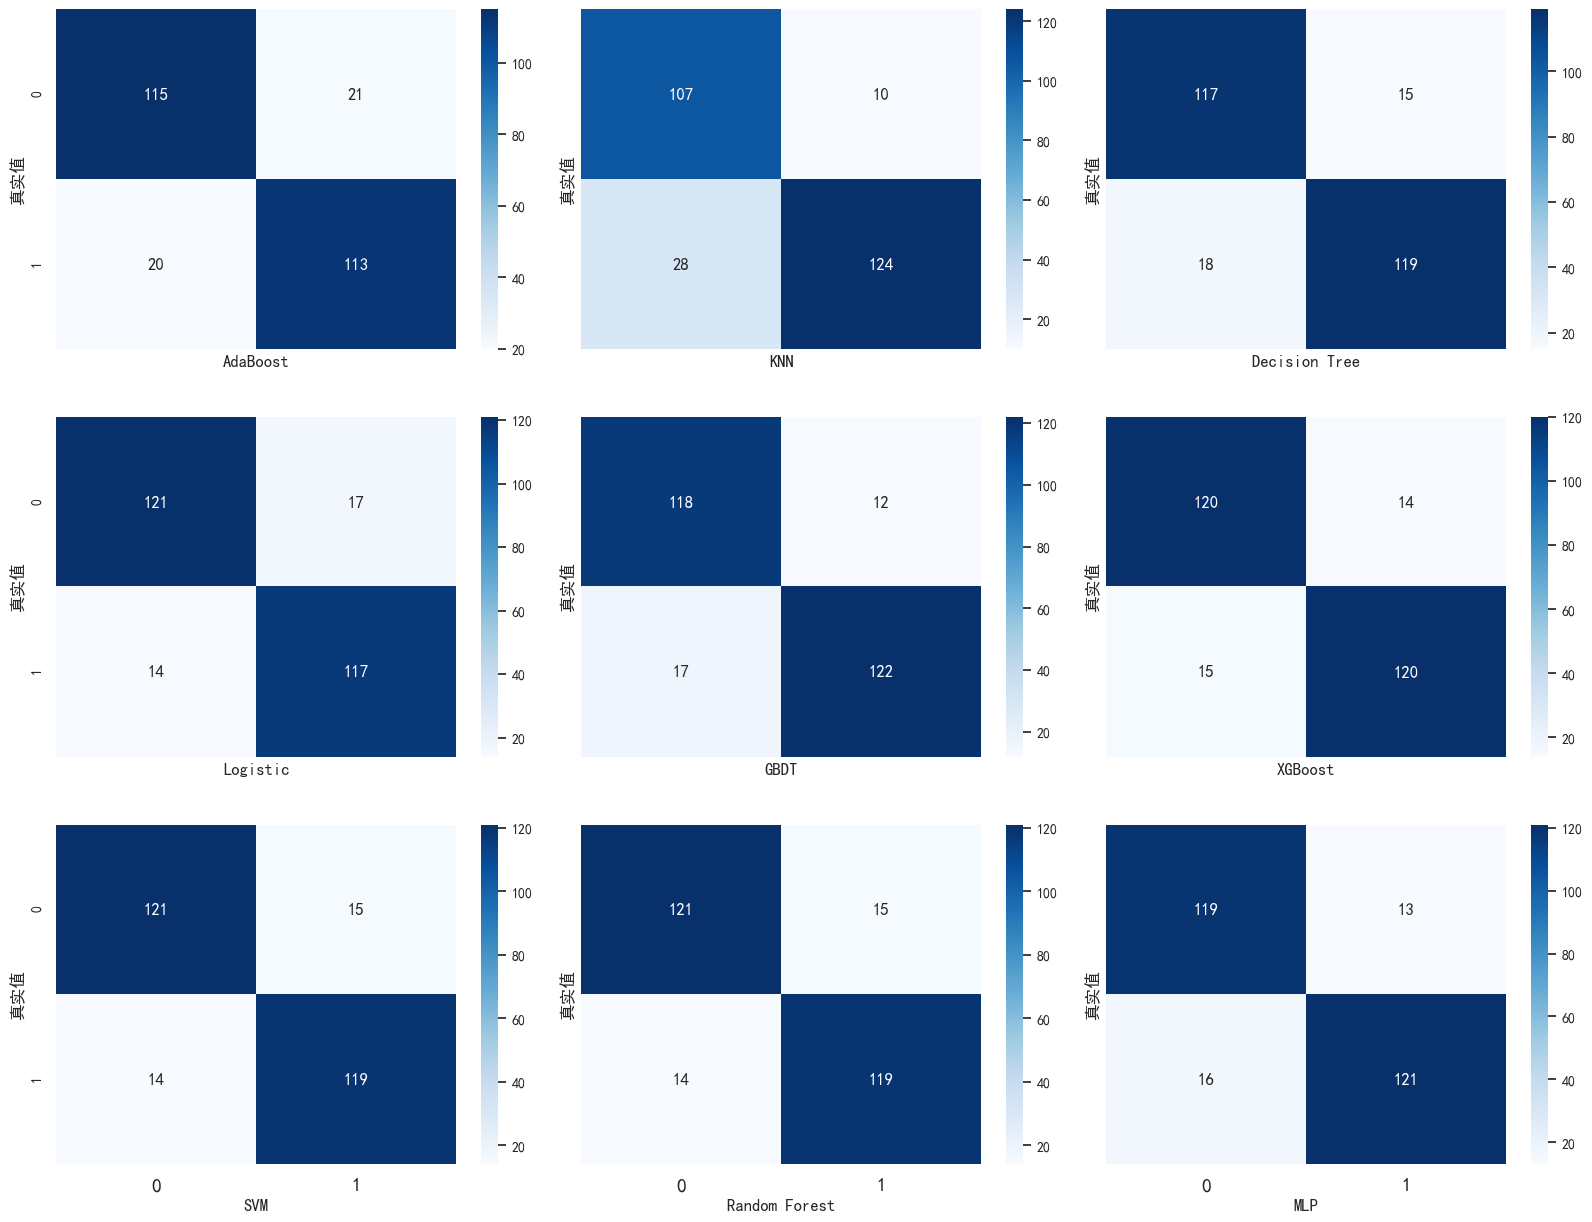

In [239]:
fig, ax = plt.subplots(3,3,figsize=(20,15),sharey=True,sharex=True)

flag = 0
for name, model in models.items():
    
    clf = models[name].fit(X_train,Y_train)
    train_predict = clf.predict(X_train)
    test_predict = clf.predict(X_test)
    
    # 利用热力图对于结果进行可视化
    
    
    confusion_matrix_result = metrics.confusion_matrix(test_predict,Y_test)
    sns.heatmap(confusion_matrix_result, annot=True, cmap=colormap2,fmt='.50g',ax=ax[flag//3,flag%3])

    ax[flag//3,flag%3].set_xlabel(name)
    ax[flag//3,flag%3].set_ylabel("真实值")
    flag +=1
# plt.subplots_adjust(wspace=0.1,hspace=0.1)
plt.savefig(os.path.join(outputpath,"outputplot_所有模型混淆矩阵图.png"),dpi=500,bbox_inches = "tight")
plt.show()

##### ROC曲线可视化

[20:04:29] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


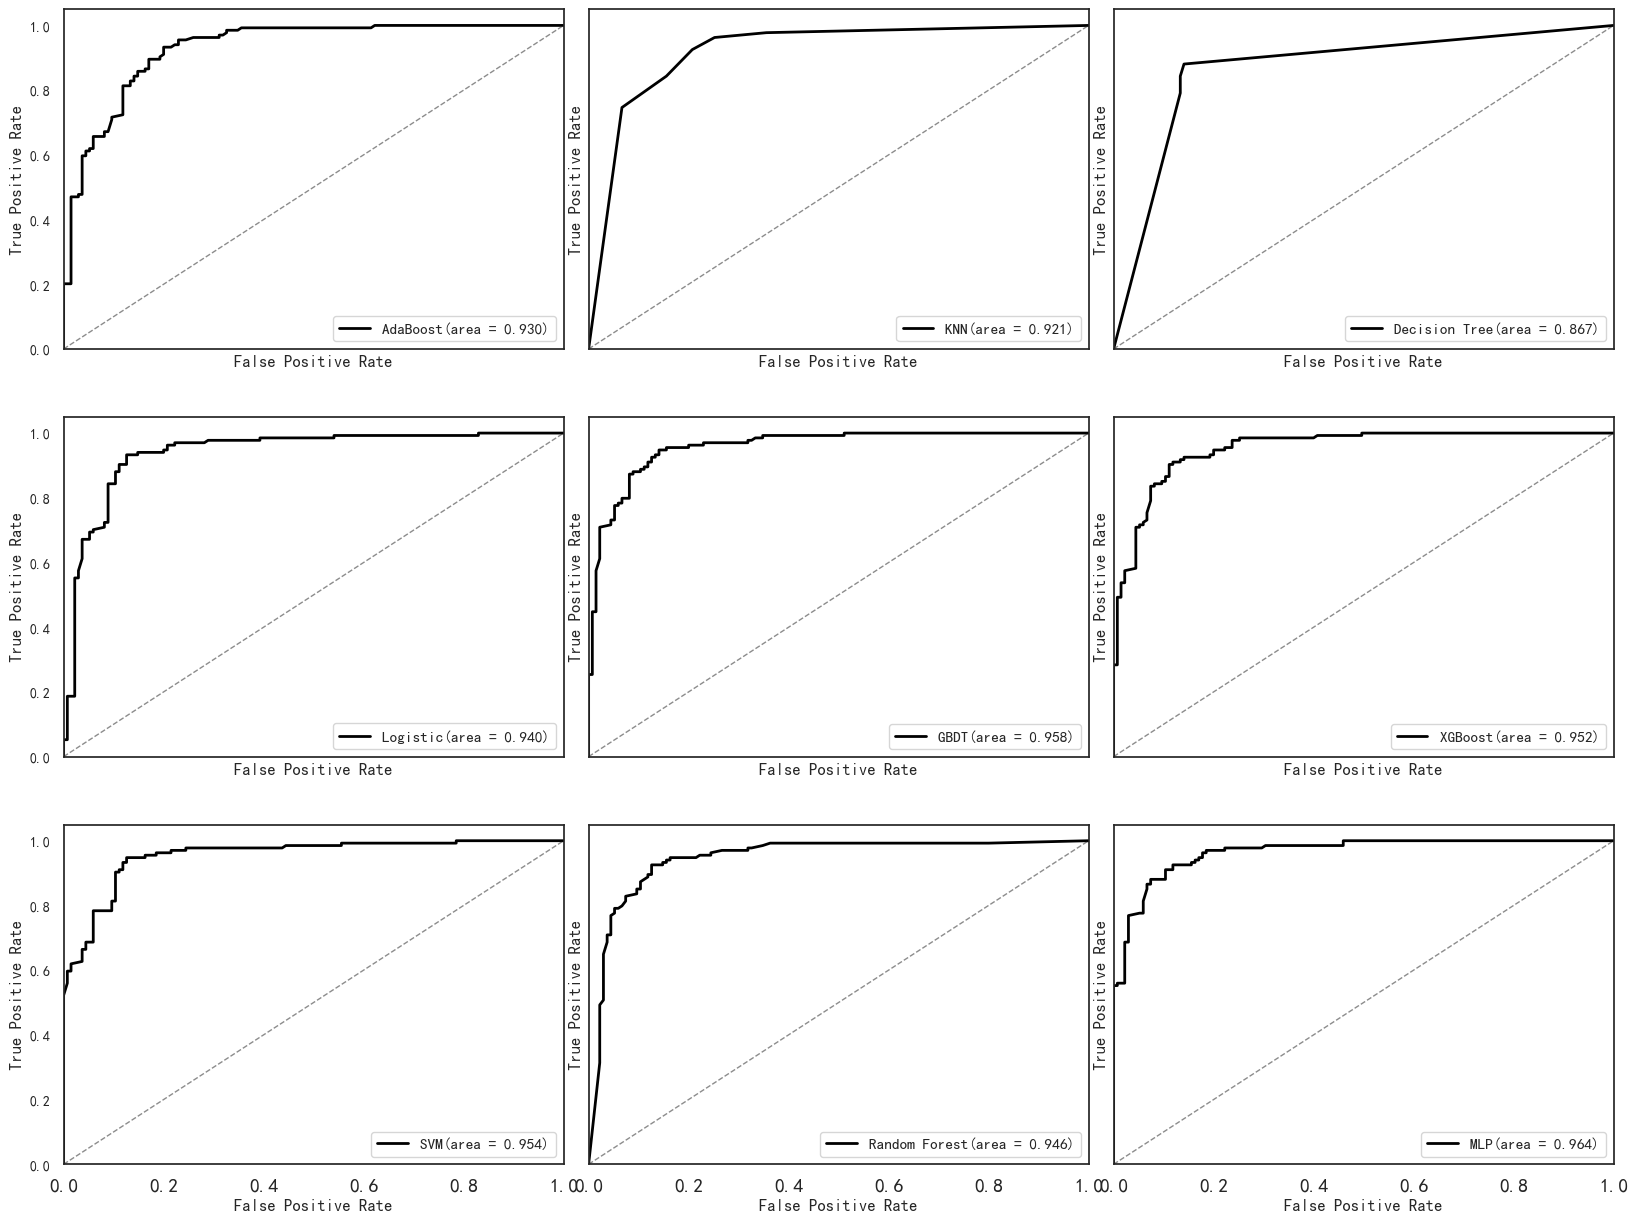

In [240]:
fig, ax = plt.subplots(3,3,figsize=(20,15),sharey=True,sharex=True)

flag = 0
for name, model in models.items():
#     if name == "KNN" or name == "Decision Tree" or name == "XGBoost":
#         continue
    clf = models[name].fit(X_train,Y_train)
    y_score = clf.predict_proba(X_test)

    fpr,tpr,threshold = metrics.roc_curve(Y_test,y_score[:,1],pos_label=1)
    roc_auc = metrics.auc(fpr,tpr)
    
    # 绘制ROC曲线
    ax[flag//3,flag%3].plot(fpr, tpr,lw=2,color="black", label='{}(area = {:.3f})'.format(name, roc_auc))

    ax[flag//3,flag%3].set_xlabel(name)
    
    
    ax[flag//3,flag%3].plot([0, 1], [0, 1], color='k', lw=1, linestyle='--',alpha=0.5)
    ax[flag//3,flag%3].set_xlim([0.0, 1.0])
    ax[flag//3,flag%3].set_ylim([0.0, 1.05])
    ax[flag//3,flag%3].set_xlabel('False Positive Rate')
    ax[flag//3,flag%3].set_ylabel('True Positive Rate')
    ax[flag//3,flag%3].legend(loc="lower right")
    flag +=1
    
    
# plt.subplots_adjust(wspace=0.1,hspace=0.1)
plt.savefig(os.path.join(outputpath,"outputplot_所有模型ROC曲线图1.png"),dpi=500,bbox_inches = "tight")
plt.show()

[20:04:34] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


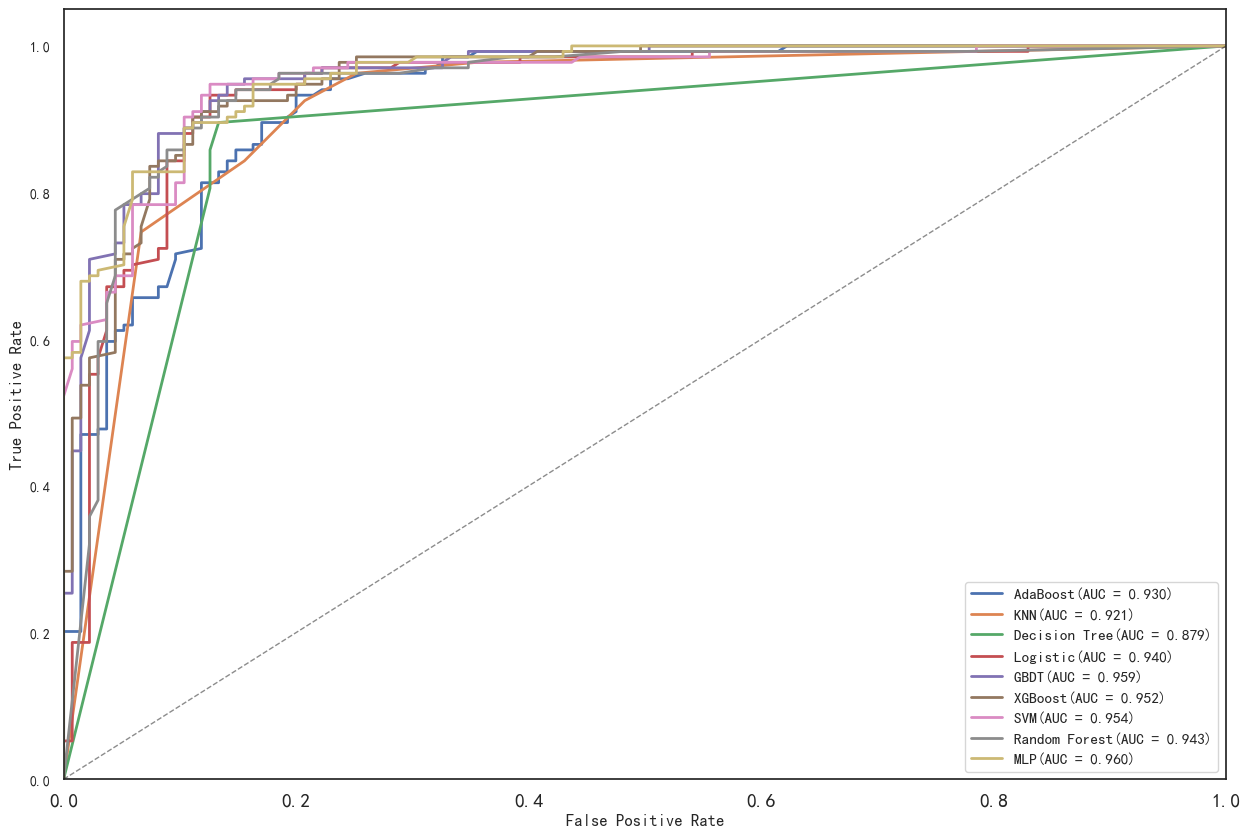

In [241]:
plt.figure(figsize=(15,10))
for name, model in models.items():
#     if name == "KNN" or name == "Decision Tree" or name == "XGBoost":
#         continue
    clf = models[name].fit(X_train,Y_train)
    y_score = clf.predict_proba(X_test)

    fpr,tpr,threshold = metrics.roc_curve(Y_test,y_score[:,1],pos_label=1)
    roc_auc = metrics.auc(fpr,tpr)
    
    # 绘制ROC曲线
    plt.plot(fpr, tpr,lw=2, label='{}(AUC = {:.3f})'.format(name, roc_auc))

plt.plot([0, 1], [0, 1], color="k", lw=1, linestyle='--',alpha=0.5)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
# plt.subplots_adjust(wspace=0.1,hspace=0.1)
plt.savefig(os.path.join(outputpath,"outputplot_所有模型ROC曲线图2.png"),dpi=500,bbox_inches = "tight")
plt.show()


##### 交叉验证

AdaBoost : [0.85501859 0.89219331 0.84758364 0.83271375 0.86245353 0.88475836
 0.84386617 0.88847584 0.85130112 0.88475836]
KNN : [0.866171   0.89962825 0.866171   0.84386617 0.87732342 0.89591078
 0.87732342 0.91449814 0.866171   0.88104089]
Decision Tree : [0.89219331 0.89591078 0.88847584 0.86988848 0.86245353 0.88104089
 0.87360595 0.89219331 0.89591078 0.87360595]
Logistic : [0.88475836 0.91078067 0.86988848 0.82899628 0.89219331 0.89591078
 0.86988848 0.91821561 0.87360595 0.89962825]
GBDT : [0.89219331 0.9330855  0.89591078 0.866171   0.88104089 0.91449814
 0.87732342 0.9330855  0.90334572 0.89219331]
[20:06:43] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:06:43] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary

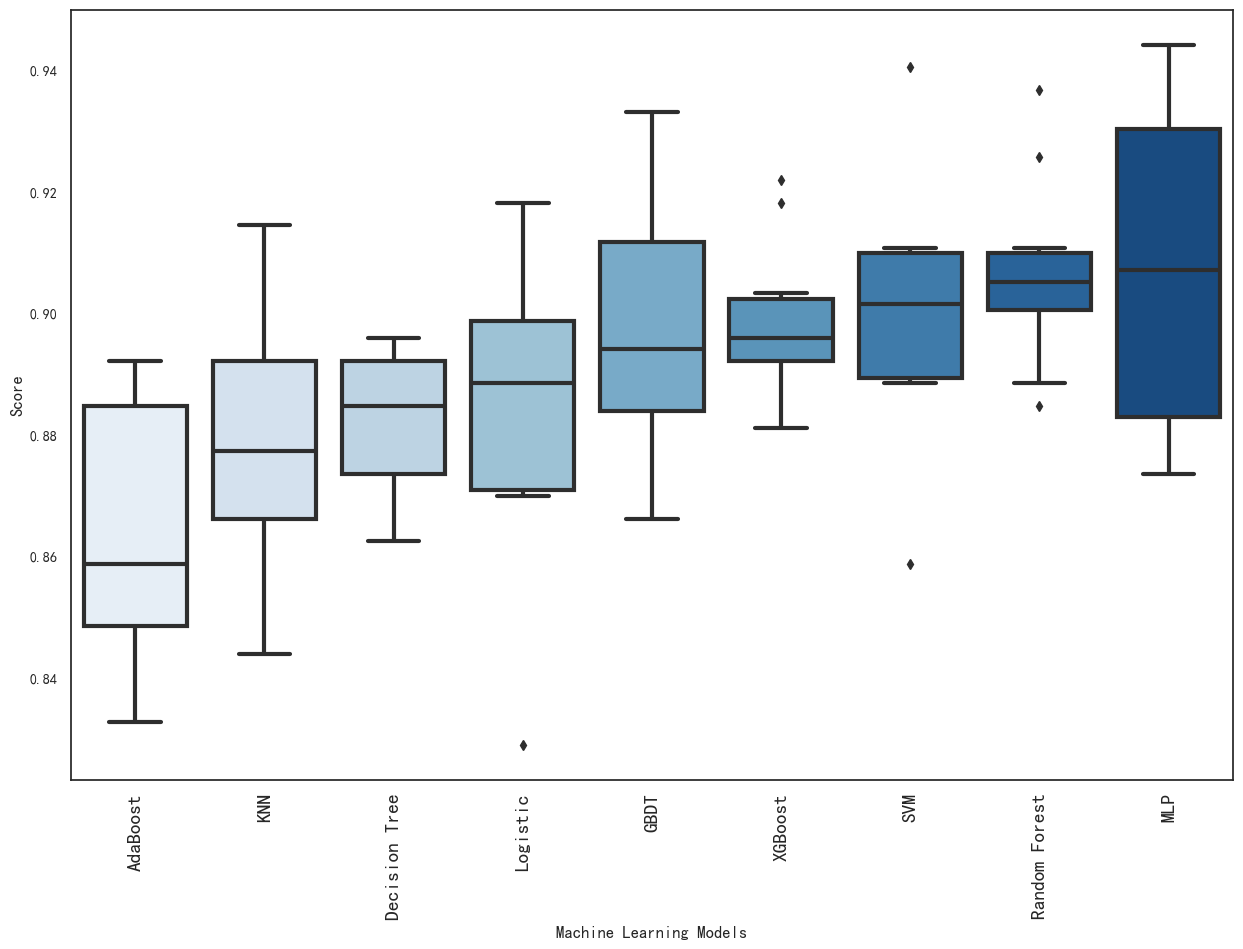

In [250]:
# 建立交叉模型
scores_dict = {}
for name,model in models.items():

    cv = ShuffleSplit(n_splits=10, test_size=.3, random_state=0) 
    scores_CV = cross_val_score(model, X_data,Y_data, cv=cv)
    print(name,":",scores_CV)
    scores_dict[name] = scores_CV  # 保存交叉验证评分结果
df_scoresCV = pd.DataFrame(scores_dict).round(3)
df_scoresCV.to_csv(os.path.join(outputpath,"outputdata2_交叉验证得分结果.csv"),index=True,header=True)


# 可视化绘制箱线图
score_plotdata = pd.DataFrame(scores_dict).melt()

plt.figure(figsize=(15,10))
# sns.set(style="white")
color_p = sns.color_palette(colormap2,9)
sns.boxplot(x="variable", y="value",data=score_plotdata,palette=color_p)
plt.xticks(rotation=90)
plt.xlabel("Machine Learning Models")
plt.ylabel("Score")

plt.savefig(os.path.join(outputpath,"outputplot2_交叉验证得分结果箱线图.png"),dpi=500, bbox_inches = "tight")
plt.show()

#### 变量重要性

[20:04:50] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


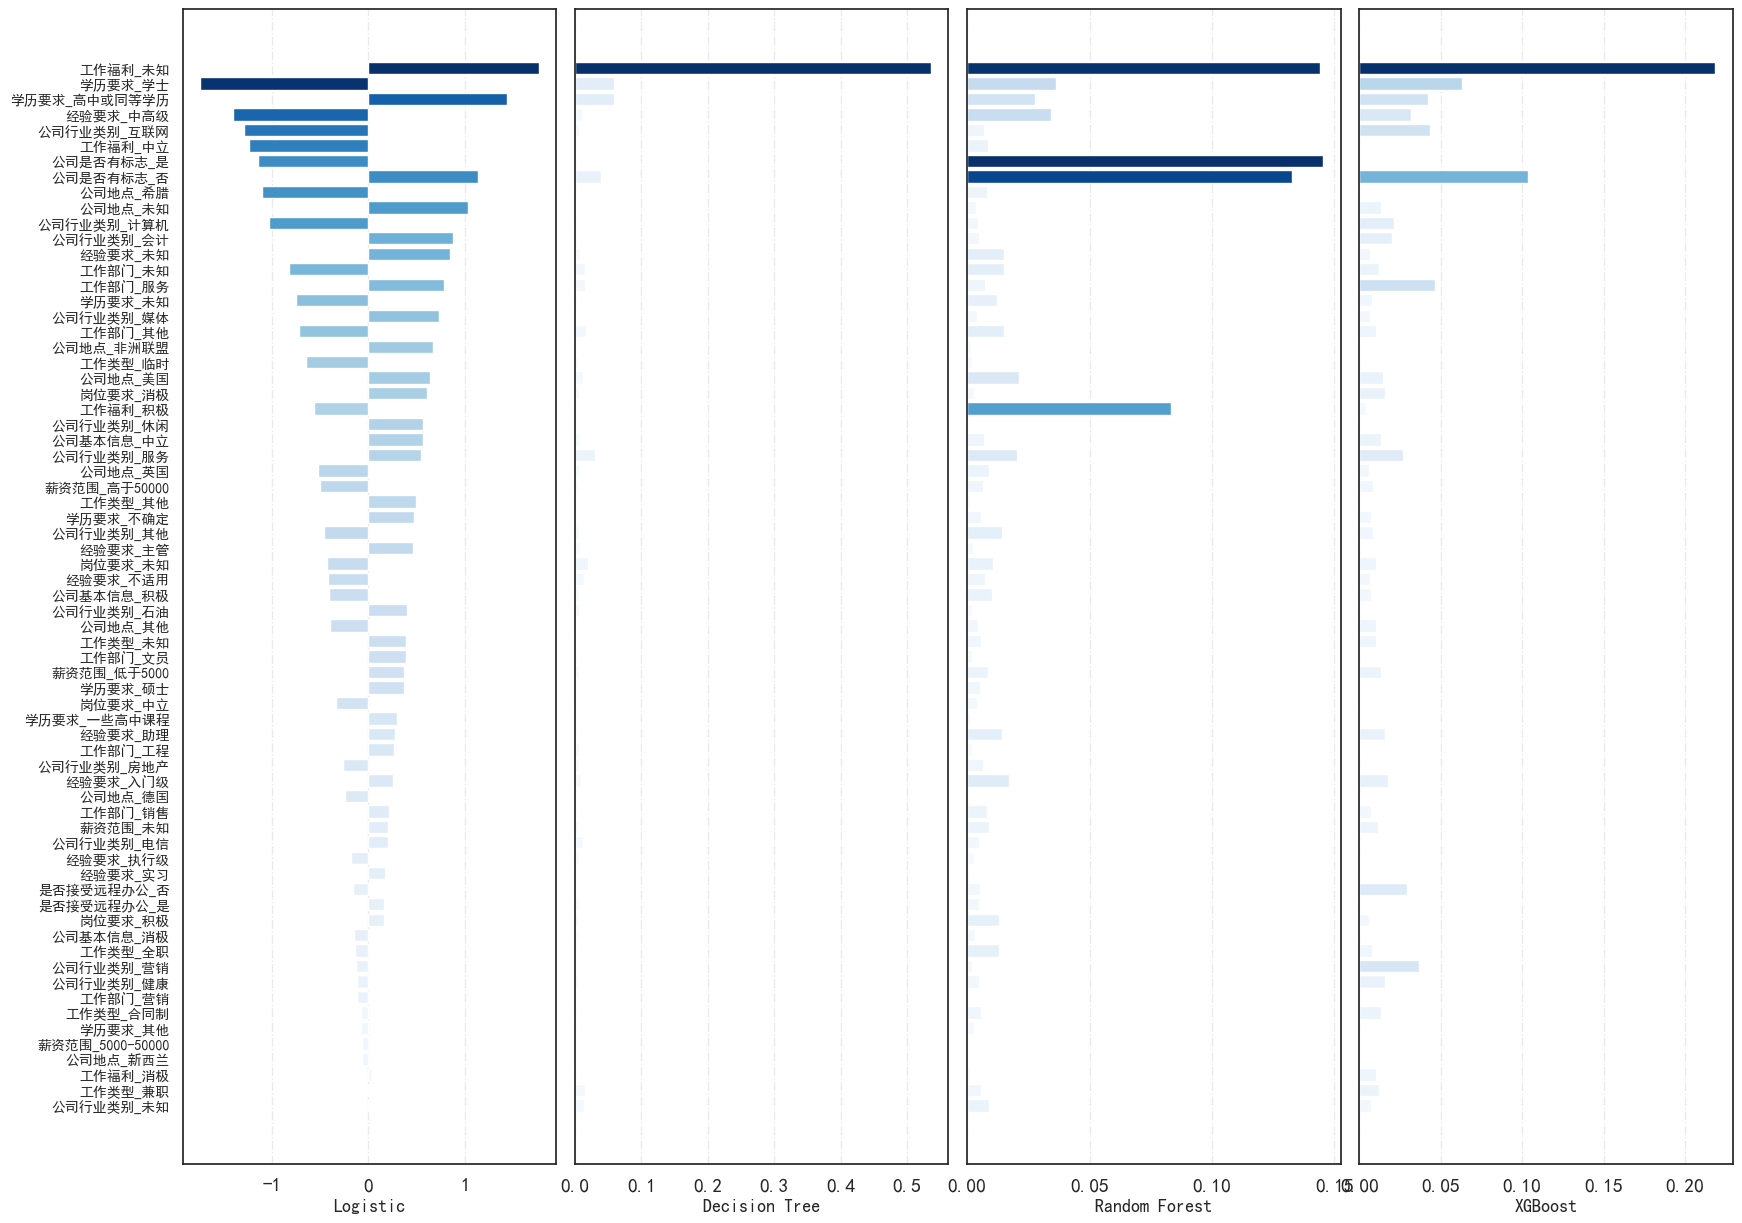

In [243]:
fig, ax = plt.subplots(1,4,figsize=(20,15),sharey=True)

flag = 0

models2 = {
        "Logistic":LogisticRegression(),
        "Decision Tree":DecisionTreeClassifier(),
        "Random Forest":RandomForestClassifier(),
        "XGBoost":XGBClassifier(),
        }

for name, model in models2.items():
    if name == "Logistic" or name == "Decision Tree" or name == "Random Forest" or name == "XGBoost" :
        
        clf = models2[name].fit(X_train,Y_train)
        
        if name == "Logistic":
            importance = clf.coef_
        else:
            importance = clf.feature_importances_
        # 变量重要性排序
        coef = pd.DataFrame({'var' : X_test.columns,
                                'coef' : importance.flatten()
                                })

        coef_sort0 = coef["coef"].sort_values(ascending=False)
        if flag == 0:
            index_sort =  np.abs(coef['coef']).sort_values().index
        coef_sort = coef.loc[index_sort,:]


        # 水平柱形图绘图
        x, y = coef_sort['var'], coef_sort['coef']
        
        
        map_vir = cm.get_cmap(name=colormap2)
        if flag == 0:
            norm_y = plt.Normalize(min(abs(index_sort)),max(abs(index_sort)))(abs(index_sort))
        norm_y = plt.Normalize(min(abs(y)),max(abs(y)))(abs(y))
        color = map_vir(norm_y)

        rects = ax[flag%4].barh(x, y, color=color)
        ax[flag%4].grid(linestyle="-.", axis='x', alpha=0.4)
        ax[flag%4].set_xlabel(name,fontsize=13)
        flag += 1
plt.subplots_adjust(wspace=0.05,hspace=0.1)
plt.savefig(os.path.join(outputpath,"outputplot机器学模型重要性柱状图.png"),dpi=500,bbox_inches = "tight")
plt.show()

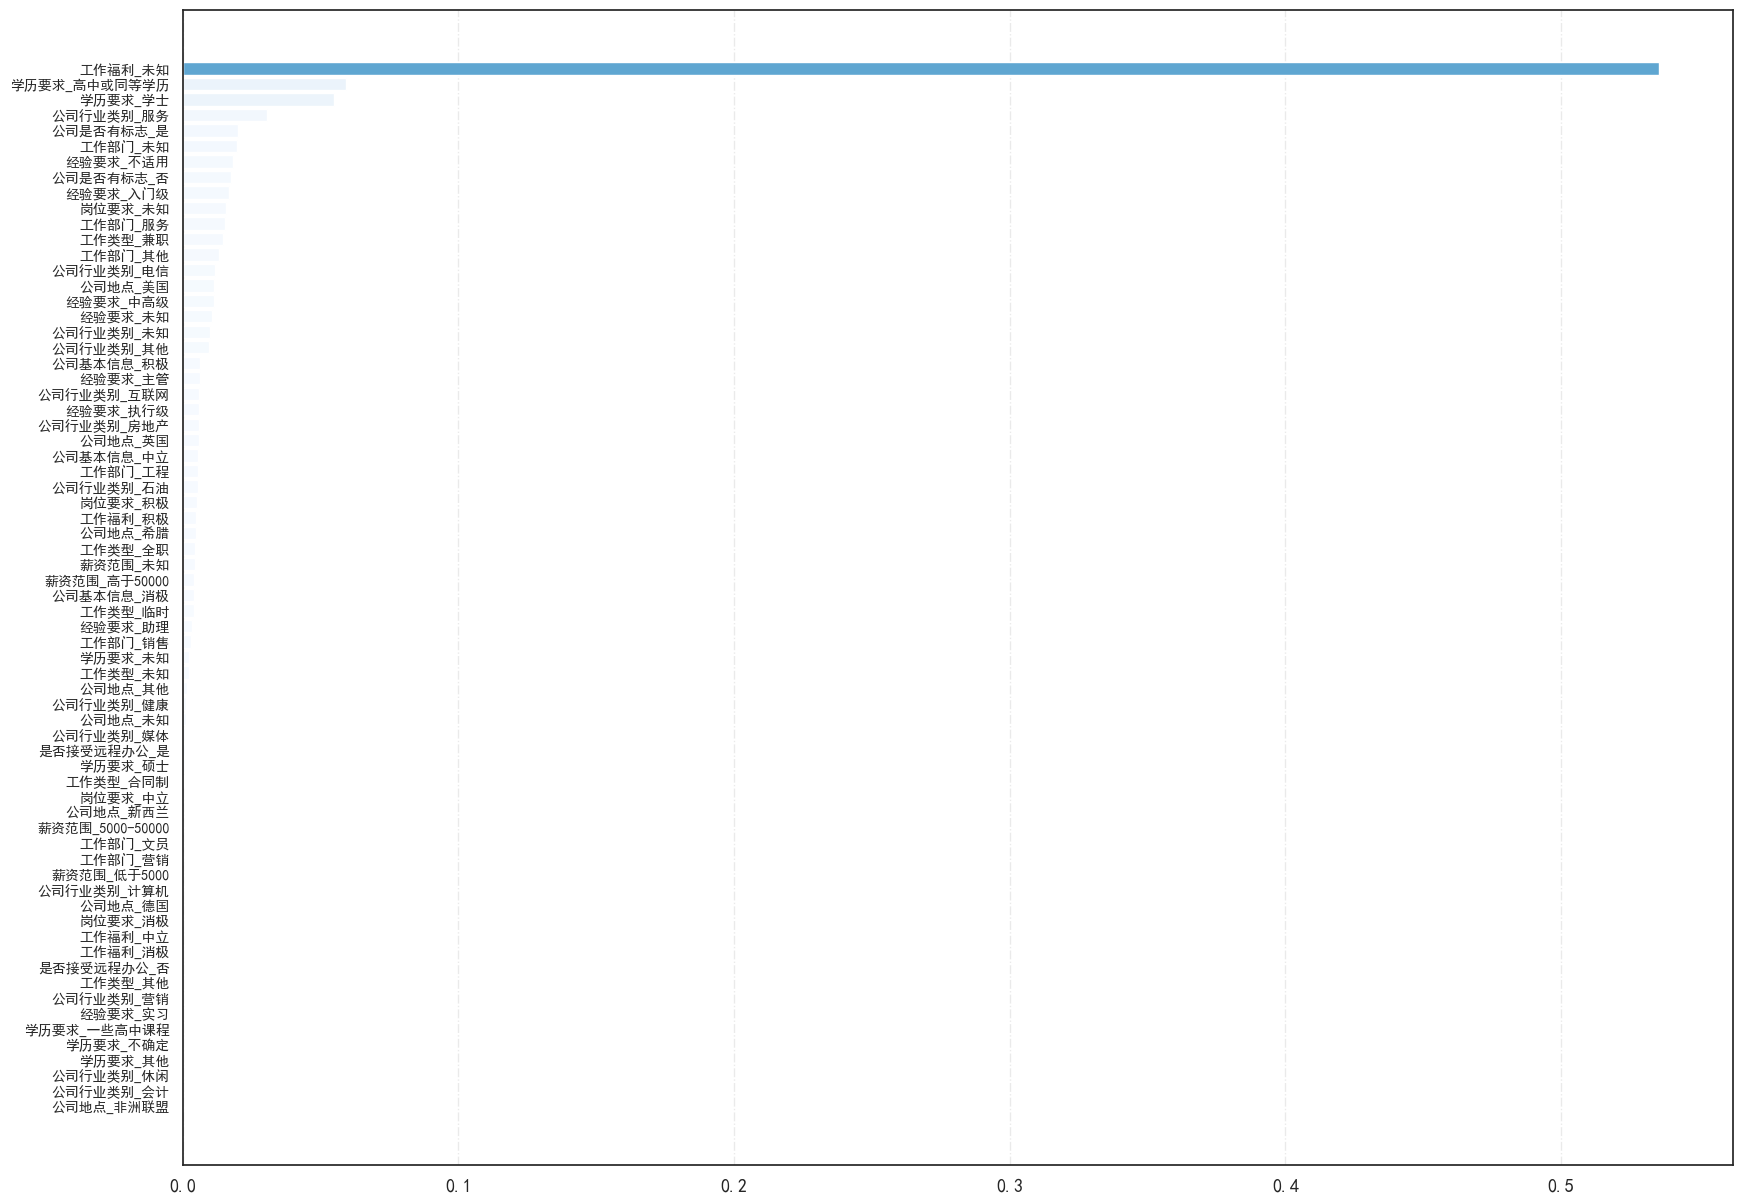

In [244]:
dt_clf = DecisionTreeClassifier().fit(X_train,Y_train)

# 变量重要性排序
coef_dt = pd.DataFrame({'var' : X_test.columns,
                        'coef' : dt_clf.feature_importances_.flatten()
                        })
coef_dt_sort0 = coef_dt.sort_values(["coef"],ascending=True)
index_sort =  np.abs(coef_dt['coef']).sort_values().index
coef_dt_sort = coef_dt.loc[index_sort,:]

# 水平柱形图绘图
fig,ax=plt.subplots(figsize=(20,15))
x, y = coef_dt_sort['var'], coef_dt_sort['coef']
map_vir = cm.get_cmap(name=colormap2)
color = map_vir(coef_dt_sort0["coef"])
rects = plt.barh(x, y, color=color)
plt.grid(linestyle="-.", axis='x', alpha=0.4)
plt.yticks(fontsize=10)
plt.xticks(fontsize=13)
plt.savefig(os.path.join(outputpath,"outputplot决策树变量重要性柱状图2.png"),dpi=500,bbox_inches = "tight")
plt.show()


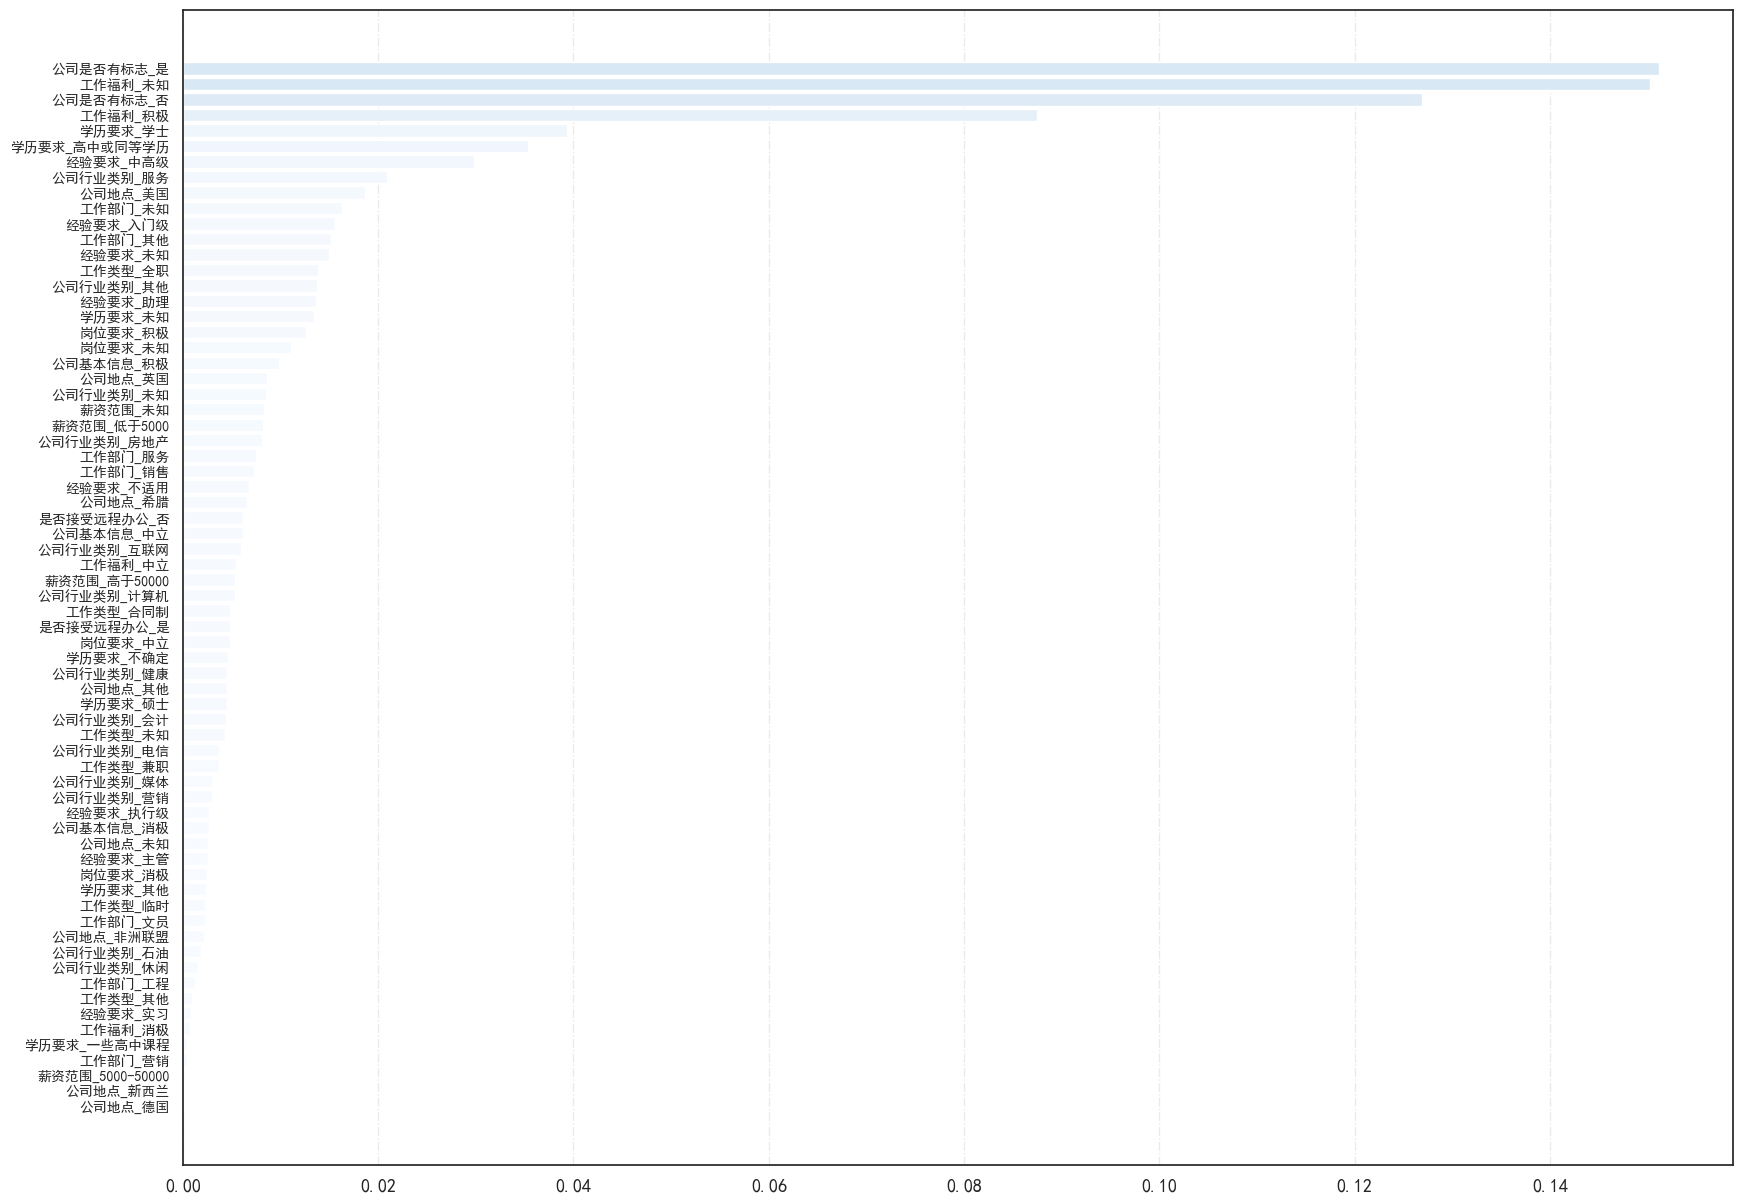

In [245]:
rf_clf = RandomForestClassifier().fit(X_train,Y_train)
# importance = rf_clf.feature_importances_
# # for i,v in enumerate(importance):
# #     print('Feature: %0d, Score: %.5f' % (i,v))
# # plot feature importance
# plt.bar([x for x in range(len(importance))], importance)
# plt.show()


# 变量重要性排序
coef_rf = pd.DataFrame({'var' : X_test.columns,
                        'coef' : rf_clf.feature_importances_.flatten()
                        })
coef_rf_sort0 = coef_rf.sort_values(["coef"],ascending=True)
index_sort =  np.abs(coef_rf['coef']).sort_values().index
coef_rf_sort = coef_rf.loc[index_sort,:]

# 水平柱形图绘图

fig,ax=plt.subplots(figsize=(20,15))
x, y = coef_rf_sort['var'], coef_rf_sort['coef']
map_vir = cm.get_cmap(name=colormap2)
color = map_vir(coef_rf_sort0["coef"])
rects = plt.barh(x, y, color=color)
plt.grid(linestyle="-.", axis='x', alpha=0.4)
plt.yticks(fontsize=10)
plt.xticks(fontsize=13)
plt.savefig(os.path.join(outputpath,"outputplot随机森林变量重要性柱状图2.png"),dpi=500,bbox_inches = "tight")
plt.show()

[20:05:06] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


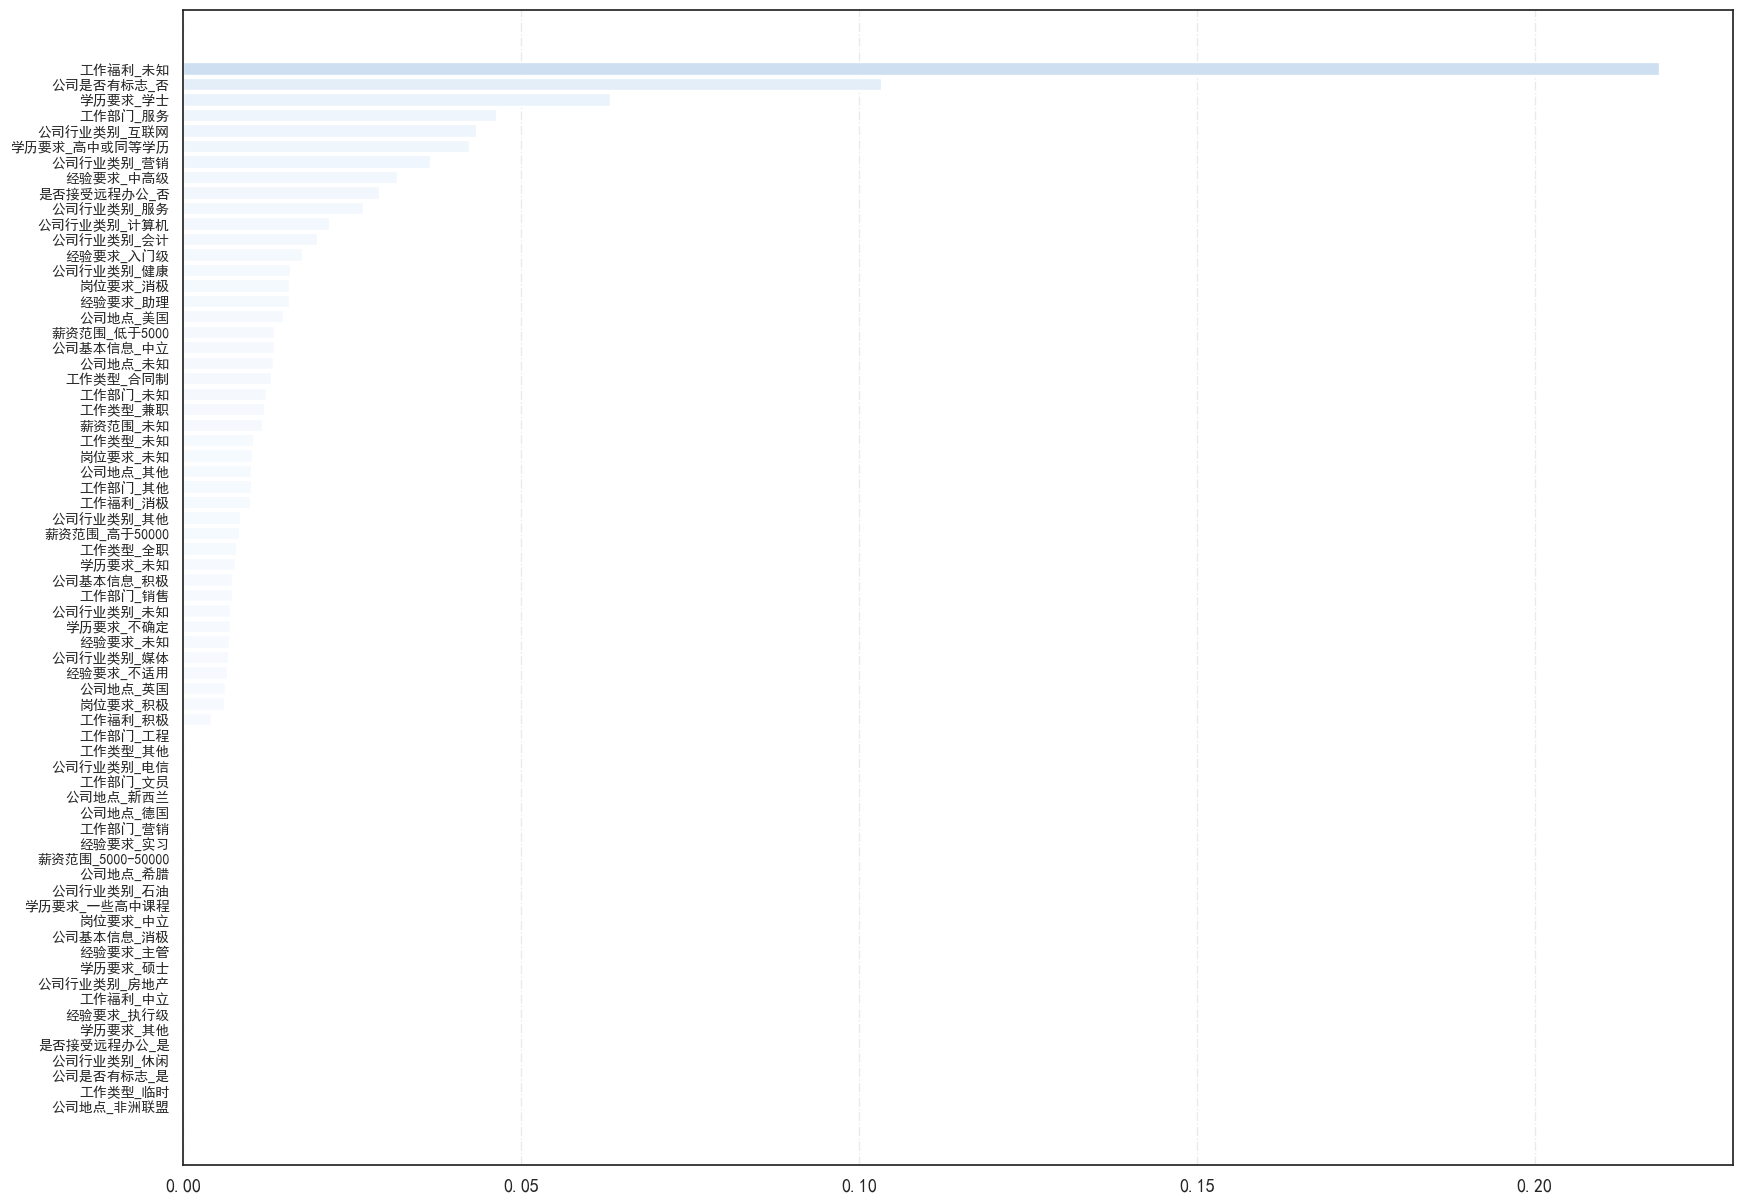

In [246]:
xgb_clf = XGBClassifier().fit(X_train,Y_train)
# importance = xgb_clf.feature_importances_
# # for i,v in enumerate(importance):
# #     print('Feature: %0d, Score: %.5f' % (i,v))
# # plot feature importance
# plt.bar([x for x in range(len(importance))], importance)
# plt.show()


# 变量重要性排序
coef_xgb = pd.DataFrame({'var' : X_test.columns,
                        'coef' : xgb_clf.feature_importances_.flatten()
                        })
coef_xgb_sort0 = coef_xgb.sort_values(["coef"],ascending=True)
index_sort =  np.abs(coef_xgb['coef']).sort_values().index
coef_xgb_sort = coef_xgb.loc[index_sort,:]

# 水平柱形图绘图

fig,ax=plt.subplots(figsize=(20,15))
x, y = coef_xgb_sort['var'], coef_xgb_sort['coef']
map_vir = cm.get_cmap(name=colormap2)
color = map_vir(coef_xgb_sort0["coef"])
rects = plt.barh(x, y, color=color)
plt.grid(linestyle="-.", axis='x', alpha=0.4)
plt.yticks(fontsize=10)
plt.xticks(fontsize=13)
plt.savefig(os.path.join(outputpath,"outputplotXGBoost变量重要性柱状图2.png"),dpi=500,bbox_inches = "tight")
plt.show()

In [247]:
cmp